In [ ]:
!pip install kaggle

In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p /content/data
!kaggle datasets download -d amananandrai/ag-news-classification-dataset -p /content/data
!unzip -o /content/data/ag-news-classification-dataset.zip -d /content/data
!ls -lah /content/data

Dataset URL: https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset
License(s): unknown
  0% 0.00/11.4M [00:00<?, ?B/s]
100% 11.4M/11.4M [00:00<00:00, 944MB/s]
Archive:  /content/data/ag-news-classification-dataset.zip
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  
total 41M
drwxr-xr-x 2 root root 4.0K Aug 26 15:06 .
drwxr-xr-x 1 root root 4.0K Aug 26 15:06 ..
-rw-r--r-- 1 root root  12M Apr 20  2020 ag-news-classification-dataset.zip
-rw-r--r-- 1 root root 1.8M Apr 20  2020 test.csv
-rw-r--r-- 1 root root  28M Apr 20  2020 train.csv


In [4]:
import pandas as pd

train_path = "/content/data/train.csv"

def load_agnews(train_csv):

    df = pd.read_csv(train_csv, encoding="utf-8", on_bad_lines="skip")

    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]


    expected_like = set(df.columns)
    if not {"class_index","title","description"}.issubset(expected_like) and \
       not {"label","title","description"}.issubset(expected_like):
        df = pd.read_csv(
            train_csv,
            encoding="utf-8",
            header=None,
            names=["label","title","description"],
            on_bad_lines="skip"
        )
        df.columns = ["label","title","description"]
    else:

        rename_map = {}
        if "class_index" in df.columns: rename_map["class_index"] = "label"
        if "title" in df.columns:       rename_map["title"]       = "title"
        if "description" in df.columns:  rename_map["description"] = "description"
        df = df.rename(columns=rename_map)


    keep = ["label","title","description"]
    df = df[[c for c in keep if c in df.columns]].copy()


    df["label"] = pd.to_numeric(df["label"], errors="coerce")
    df = df[df["label"].isin([1,2,3,4])].copy()


    df["title"] = df["title"].fillna("")
    df["description"] = df["description"].fillna("")
    df["text"] = (df["title"] + " " + df["description"]).str.strip()

    return df

df = load_agnews(train_path)
print(df.head(3))
print("\nClass counts:\n", df["label"].value_counts().sort_index())
print("\nColumns:", df.columns.tolist(), " | Rows:", len(df))

   label                                              title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   

                                         description  \
0  Reuters - Short-sellers, Wall Street's dwindli...   
1  Reuters - Private investment firm Carlyle Grou...   
2  Reuters - Soaring crude prices plus worries\ab...   

                                                text  
0  Wall St. Bears Claw Back Into the Black (Reute...  
1  Carlyle Looks Toward Commercial Aerospace (Reu...  
2  Oil and Economy Cloud Stocks' Outlook (Reuters...  

Class counts:
 label
1    30000
2    30000
3    30000
4    30000
Name: count, dtype: int64

Columns: ['label', 'title', 'description', 'text']  | Rows: 120000


In [5]:
import re

def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-z\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["cleaned"] = df["text"].apply(clean_text)

In [6]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["cleaned"])
y = df["label"]



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

target_names = ["World","Sports","Business","Sci/Tech"]
print(
    classification_report(
        y_test, y_pred,
        labels=[1,2,3,4],
        target_names=target_names,
        zero_division=0
    )
)

Accuracy: 0.8955416666666667
              precision    recall  f1-score   support

       World       0.90      0.89      0.90      6000
      Sports       0.93      0.97      0.95      6000
    Business       0.88      0.85      0.86      6000
    Sci/Tech       0.87      0.87      0.87      6000

    accuracy                           0.90     24000
   macro avg       0.90      0.90      0.90     24000
weighted avg       0.90      0.90      0.90     24000



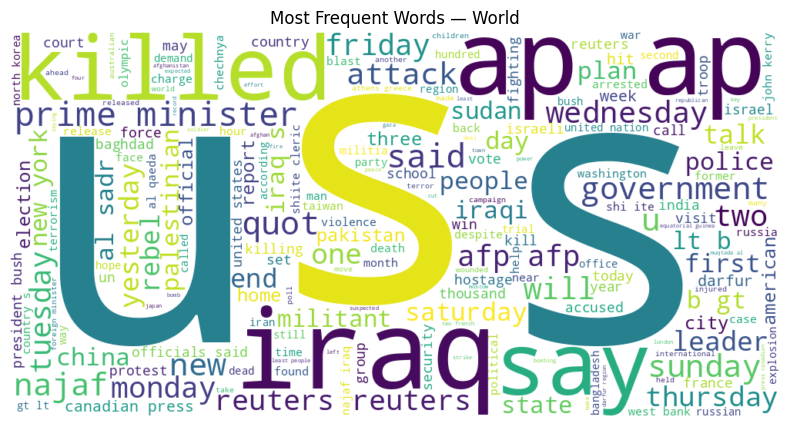

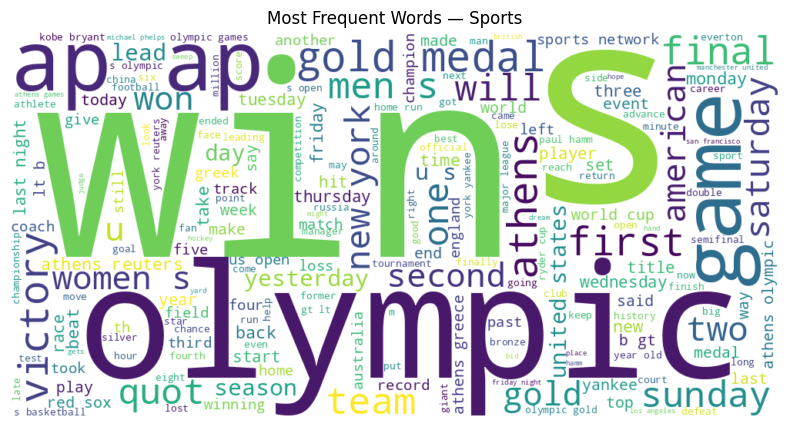

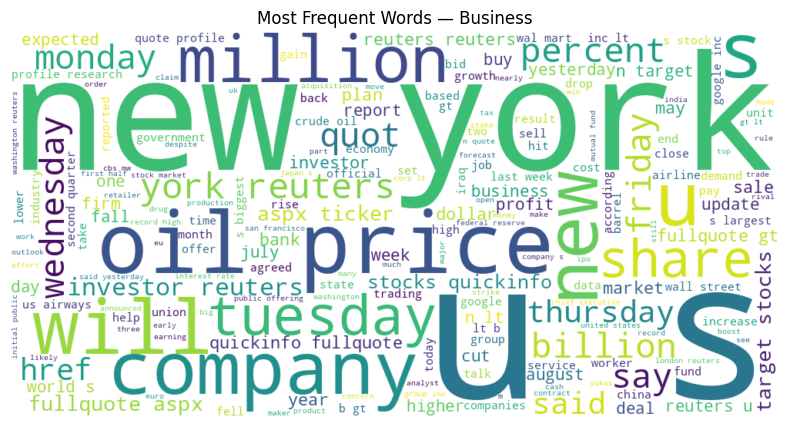

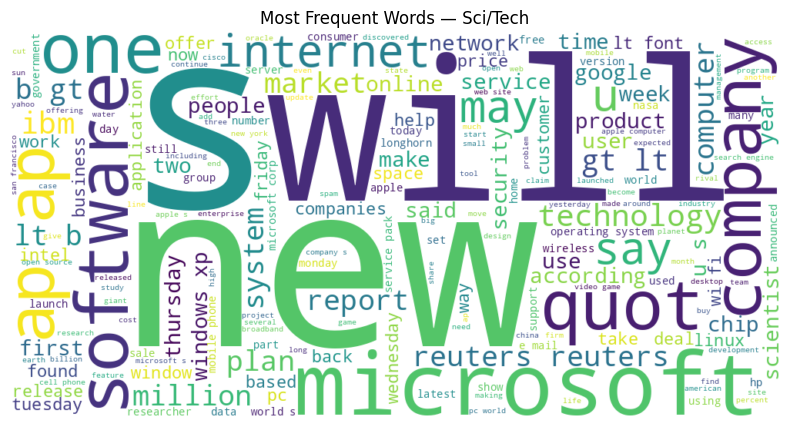

In [7]:

!pip -q install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

labels_to_names = {1:"World", 2:"Sports", 3:"Business", 4:"Sci/Tech"}

for lab, name in labels_to_names.items():
    text_blob = " ".join(df.loc[df["label"]==lab, "cleaned"].head(5000))
    if not text_blob:
        continue
    wc = WordCloud(width=1000, height=500, background_color="white").generate(text_blob)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Most Frequent Words — {name}")
    plt.show()